In [ ]:
#future 30 days
#7 days past

# Import necessary libraries 


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, sum, lit, to_date
import matplotlib.pyplot as plt
import pyspark.sql.functions as psf
import pandas as pd
import seaborn as sns
import numpy as np
import keras
import math
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, sum, lit
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import pyspark.sql.functions as psf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore") 



# Create a spark Session

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("CA01_Sem_02").config("spark.executor.memory","10g").getOrCreate()
spark

24/03/22 15:06:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Data_Ingestion Module
 To leverage the use of hadoop,  this module was created to read the csv files into a pyspark dataframe and save on hadoop hdfs system

In [3]:

# data_ingestion function: Loads all CSV files in a directory using PySpark and saves them to a specified output path on HDFS.
# Args: 
    # path: Path to the directory containing CSV files  
    # hd_path: Hadoop path on HDFS to save the processed files

def data_ingestion( path, hd_path):
    
    try:
        # Read all files in the directory matching the CSV extension (*.csv)
        df = spark.read.csv(path, header=True, inferSchema = True)

        # Save the DataFrame to Hadoop server - HDFS
        df.write.mode("overwrite").csv(hd_path, header=True)
        print('Data Ingestion Completed')

    except Exception as e:
        print("An error occurred:", e)
    
    
    

# Running the data_ingestion function

In [14]:

# path to directory where the files are
path = "file:///home/hduser/Documents/CA01_Sem_02_MSc_Data_Analytics/*.csv"

# path where the files should be saved on hadoop
hd_path = "/user/hduser/bike_data/"

# Call the processing function
data_ingestion(path, hd_path)


Data Ingestion Completed


### Verifying the data on hadoop

In [5]:
!hdfs dfs -ls /user/hduser/bike_data


Found 11 items
-rw-r--r--   1 hduser supergroup          0 2024-03-22 01:43 /user/hduser/bike_data/_SUCCESS
-rw-r--r--   1 hduser supergroup   96739828 2024-03-22 01:43 /user/hduser/bike_data/part-00000-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   93859490 2024-03-22 01:43 /user/hduser/bike_data/part-00001-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   93287714 2024-03-22 01:43 /user/hduser/bike_data/part-00002-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   89508134 2024-03-22 01:43 /user/hduser/bike_data/part-00003-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   86649859 2024-03-22 01:43 /user/hduser/bike_data/part-00004-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   86128007 2024-03-22 01:43 /user/hduser/bike_data/part-00005-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   78088682 20

# Load data from hadoop

In [41]:

hd_path = "/user/hduser/bike_data/"

try:
   

  # Read the CSV files using the specified path
  df = spark.read.csv(hd_path, header = True, inferSchema = True)

  # Print the first few rows of the DataFrame (optional)
  df.show(2)

   
except Exception as e:
    print("An error occurred:", str(e))


+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat| start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+-----------------+------------------+-------------+
|20CAF4CAD9186B1C|  docked_bike|2023-03-26 16:52:35|2023-03-26 17:22:08|Washington & Inde...|           31272|15th St & Constit...|         31321|38.886978|-77.013769|        38.892244|        -77.033234|       casual|
|695D9110D59A0A42| classic_bike|2023-03-28 16:51:30|2023-03-28 17:06:32|      11th & C St SE|           31659|D St & Marylan

In [42]:
df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



### Checking the shape of the dataframe\


In [43]:
print((df.count(), len(df.columns)))

(4467334, 13)


When it comes to using RNNs for time series forecasting or analysis, the data structure must have some level of consistency, as each row of the dataset represents one trip, only  a new column was created to represent the tripa and only  date and trips were selected from the dataset

In [44]:
trips = df.select("started_at")

In [45]:
trips.show(5)

+-------------------+
|         started_at|
+-------------------+
|2023-03-26 16:52:35|
|2023-03-28 16:51:30|
|2023-03-28 19:25:55|
|2023-03-03 16:33:58|
|2023-03-11 14:31:24|
+-------------------+
only showing top 5 rows



In [46]:
trips = trips.withColumn("started_at",to_date(col("started_at")).alias("date"))

In [47]:
trips.show(5)

+----------+
|started_at|
+----------+
|2023-03-26|
|2023-03-28|
|2023-03-28|
|2023-03-03|
|2023-03-11|
+----------+
only showing top 5 rows



In [48]:
trips = trips.withColumn("trips", lit(1))

In [49]:
trips.show(5)

+----------+-----+
|started_at|trips|
+----------+-----+
|2023-03-26|    1|
|2023-03-28|    1|
|2023-03-28|    1|
|2023-03-03|    1|
|2023-03-11|    1|
+----------+-----+
only showing top 5 rows



In [50]:
trips.printSchema()

root
 |-- started_at: date (nullable = true)
 |-- trips: integer (nullable = false)



In [54]:
#window_spec = window(trips['started_at'], "1 day")
daily_df = trips.groupBy("started_at").agg(sum("trips").alias("total_trips"))


In [56]:
daily_df = daily_df.orderBy("started_at")

In [57]:
daily_df.show(10)

+----------+-----------+
|started_at|total_trips|
+----------+-----------+
|2023-01-01|       6787|
|2023-01-02|       7240|
|2023-01-03|       7559|
|2023-01-04|       7791|
|2023-01-05|       8409|
|2023-01-06|       6719|
|2023-01-07|       7122|
|2023-01-08|       5176|
|2023-01-09|       6520|
|2023-01-10|       7303|
+----------+-----------+
only showing top 10 rows



In [58]:
daily_df.describe().show()

+-------+------------------+
|summary|       total_trips|
+-------+------------------+
|  count|               365|
|   mean|12239.271232876712|
| stddev| 3983.046929307485|
|    min|              2369|
|    max|             20174|
+-------+------------------+



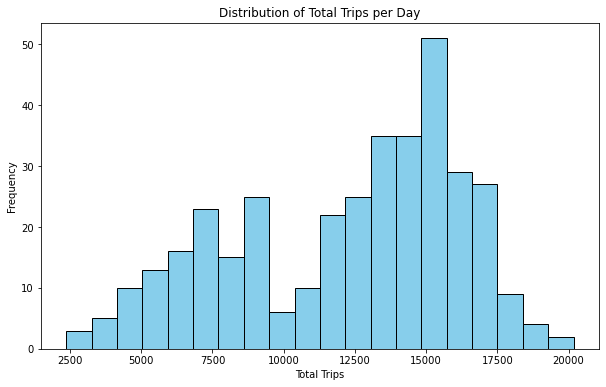

In [59]:
# Converting PySpark DataFrame to Pandas DataFrame
pandas_df = daily_df.toPandas()

# Plotting a histogram
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['total_trips'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Trips per Day')
plt.xlabel('Total Trips')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


In [10]:
pandas_df = pd.read_csv("pandas_df.csv").reset_index()

In [12]:
pandas_df = pandas_df[["started_at","total_trips"]]


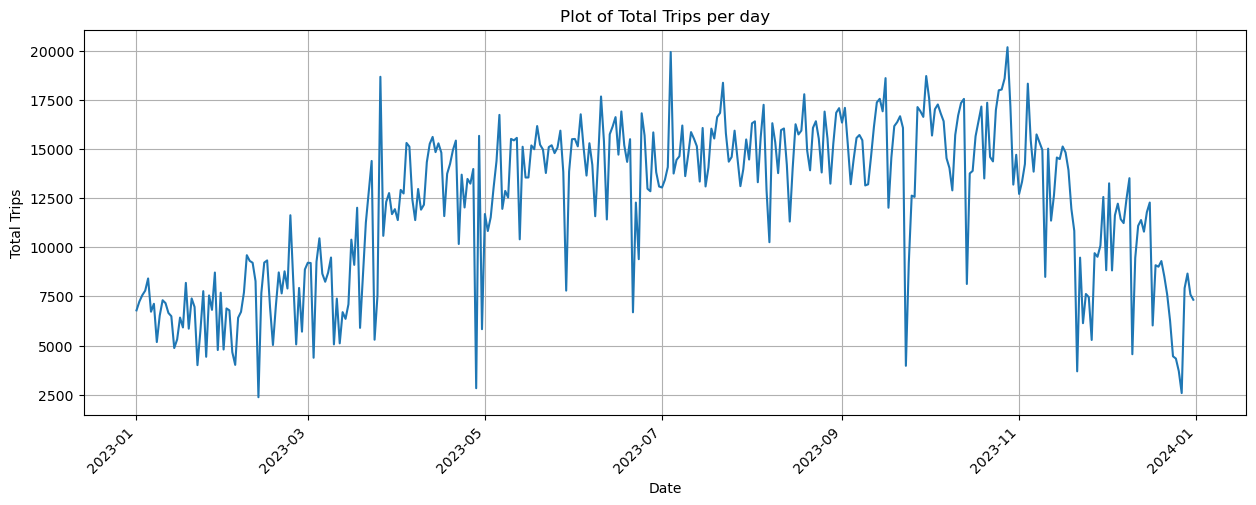

In [46]:

pandas_df['started_at'] = pd.to_datetime(pandas_df['started_at'])

plt.figure(figsize=(15, 5))

plt.plot(pandas_df["started_at"], pandas_df["total_trips"])

plt.xlabel("Date")
plt.ylabel("Total Trips")
plt.title("Plot of Total Trips per day")
plt.xticks(rotation=45, ha='right')
plt.grid(True) 
plt.show()


In [43]:
trips = pandas_df.iloc[:,-1]

In [44]:
type(trips)

pandas.core.series.Series

# LSTM Model Building:



    For building a LSTM model, its important to observe some parameters:
    Input layer: This layer takes the sequence of past trip counts as input. for this project, a window size of past 7 days was chosen to feed into the LSTM.
    LSTM layer: This layer is the core of the model, responsible for learning long-term dependencies in the trip count data. The model will be evaluated with different layers and numbers.
    Output layer: This layer predicts the future trip count. It will be used a single neuron with a linear activation for numerical prediction.
       
    TensorFlow is designed to work primarily with NumPy arrays. Because of this, pandas.core.series will be transform into NumPy arrays.

In [21]:


pandas_df = pd.read_csv("pandas_df.csv")
trips = pandas_df.iloc[:,-1]

# convert to numpy array
np_trips = trips.to_numpy()
np_trips = np_trips.reshape(-1,1)
type(np_trips)

numpy.ndarray

In [22]:
# Normalize the data,  the recommended scaler for LSTM is  MinMaxScaler in a range of 0,1


In [23]:
# normalize the dataset  ----------------
scaler = MinMaxScaler(feature_range=(0, 1))
np_trips = scaler.fit_transform(np_trips)


In [24]:
# split into train and test sets
train_size = int(len(np_trips) * 0.8)
test_size = len(np_trips) - train_size
train, test = np_trips[0:train_size,:], np_trips[train_size:len(np_trips),:]

    The next thing we need to do is to specify our number of timesteps. Timesteps specify how many previous observations should be considered when the recurrent neural network makes a prediction about the current observation.
    We will use 7 (week based) timesteps. This means that for every day that the neural network predicts, it will consider the previous 7 days of trips to determine its output. 


In [25]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=7):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [26]:
# reshape into X=t and Y=t+1
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [27]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [28]:
trainX.shape, testX.shape

((284, 1, 7), (65, 1, 7))

In [12]:
# create and fit the LSTM network
model1 = Sequential()
model1.add(LSTM(64, activation='relu',input_shape=(1, look_back)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:

model1.fit(trainX, trainY, epochs=100, batch_size=32, verbose=0)

In [15]:
# make predictions
trainPredict = model1.predict(trainX)
testPredict = model1.predict(testX)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [32]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [33]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2335.66 RMSE
Test Score: 2812.38 RMSE


RMSE (Root Mean Squared Error):

    It measures the difference between predicted and actual trip counts.
    Lower RMSE indicates better performance. Ideally, you want the error to be as small as possible.

Training vs Test Score:

    The training score (0.13) is slightly lower than the test score (0.17), which is a good sign. It indicates that the model is not overfitting to the training data and can generalize somewhat well to unseen data (test set).

Interpretation:

    An RMSE of 0.13 on the training data suggests that on average, the model's predictions are off by about 0.13 times the scale of your trip count data.
    The test score of 0.17 indicates a slightly higher average error on unseen data, but it's still relatively low.

Considering the Data Size:

    With a limited dataset size of 365 days, achieving very low RMSE scores might be challenging. The model might not be able to capture all the complex variations in the daily trip counts.

Overall Assessment:

These scores suggest that the LSTM model is capturing some underlying patterns in the trip count data and can make reasonable predictions. However, there's still room for improvement.

In [18]:
#shift train predictions for plotting
trainPredictPlot = np.empty_like(np_trips)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# shift test predictions for plotting
testPredictPlot = np.empty_like(np_trips)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(np_trips)-1, :] = testPredict


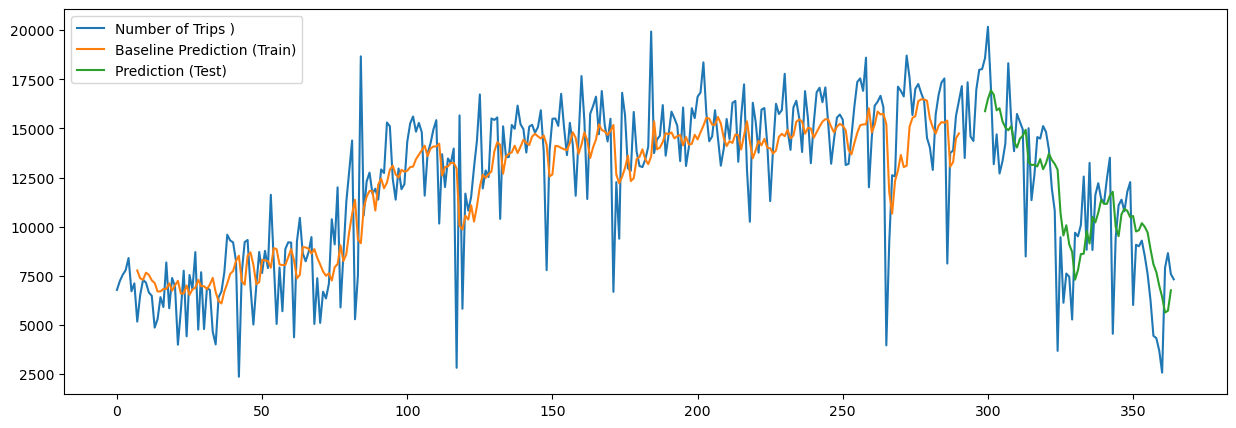

In [34]:
# plot baseline and predictions

plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(np_trips))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Number of Trips )', 'Baseline Prediction (Train)', 'Prediction (Test)'], loc='upper left')
plt.show()

In [29]:
# define model 02
model2 = Sequential()
model2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=( 7,look_back)))
model2.add(LSTM(50, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7, 50)          │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,851 (124.42 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# fit model
model2.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3757
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3315 
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2838 
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2330 
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1598 
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0679 
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201 
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 
Epoch 16/100
9/9 ━━━

In [31]:
# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
